In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


Первым делом считаем данные и отобразим их на графике.

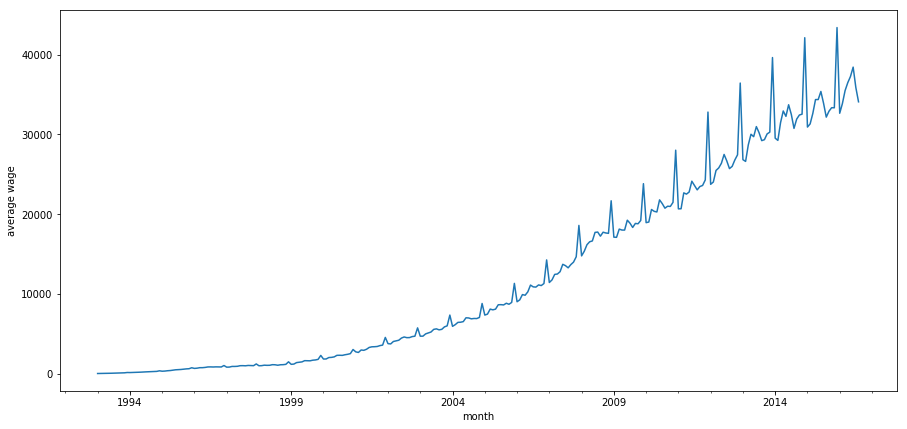

In [2]:
wage = pd.read_csv('WAG_C_M.csv', sep=';', index_col=['month'], parse_dates=['month'], dayfirst=True)
plt.figure(figsize(15,7))
wage.WAG_C_M.plot()
plt.ylabel('average wage')
pylab.show()

Видно, что ряд имеет хорошо выраженный тренд и сезонность, а также возрастающую дисперсию, и очевидно не является стационарным. Но тем не менее проверим это формально и увидим, что критерий Дики-Фуллера не отвергает нестационарность.

In [3]:
print 'Критерий Дики-Фуллера p=%f' %sm.tsa.stattools.adfuller(wage.WAG_C_M)[1]

Критерий Дики-Фуллера p=0.991850


По графику видно, что необходима стабилизация дисперсии, для этого используем преобразование Бокса-Кокса.

In [4]:
wage['wage_box'], lmbd = stats.boxcox(wage.WAG_C_M)

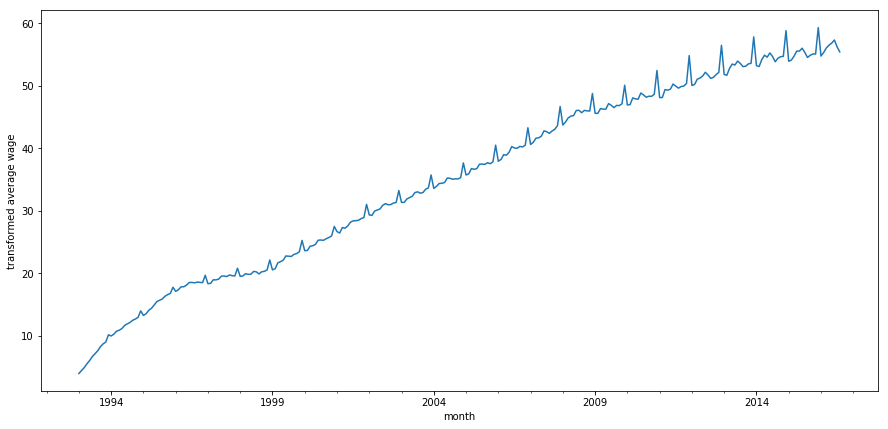

Критерий Дики-Фуллера p=0.696899


In [5]:
plt.figure(figsize(15,7))
wage['wage_box'].plot()
plt.ylabel('transformed average wage')
pylab.show()
print 'Критерий Дики-Фуллера p=%f' %sm.tsa.stattools.adfuller(wage['wage_box'])[1]

Критерий Дики-Фуллера все еще не отвергает гипотезу о нестационарности, так что используем сезонное дифференцирование

Критерий Дики-Фуллера: p=0.014697


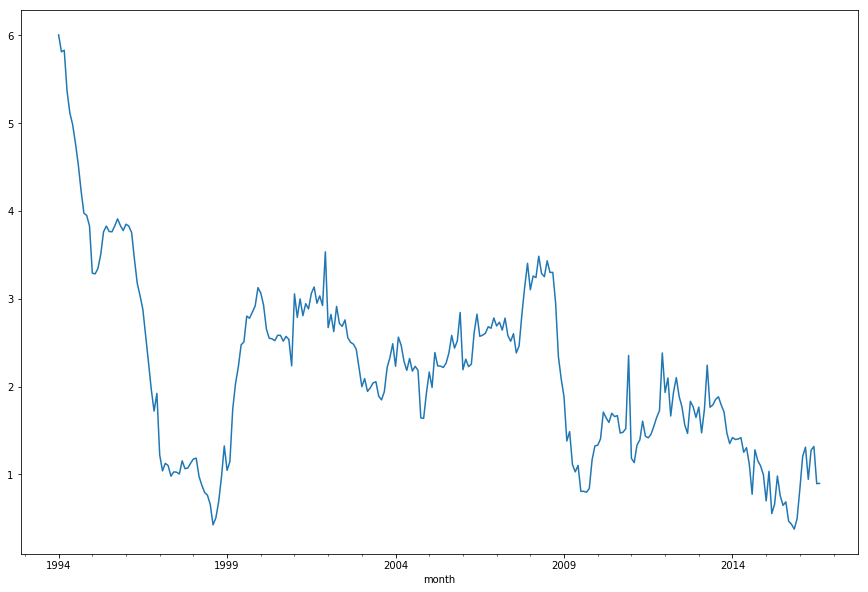

In [6]:
wage['wage_box_diff'] = wage.wage_box - wage.wage_box.shift(12)
plt.figure(figsize(15,10))
wage.wage_box_diff[12:].plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wage.wage_box_diff[12:])[1])

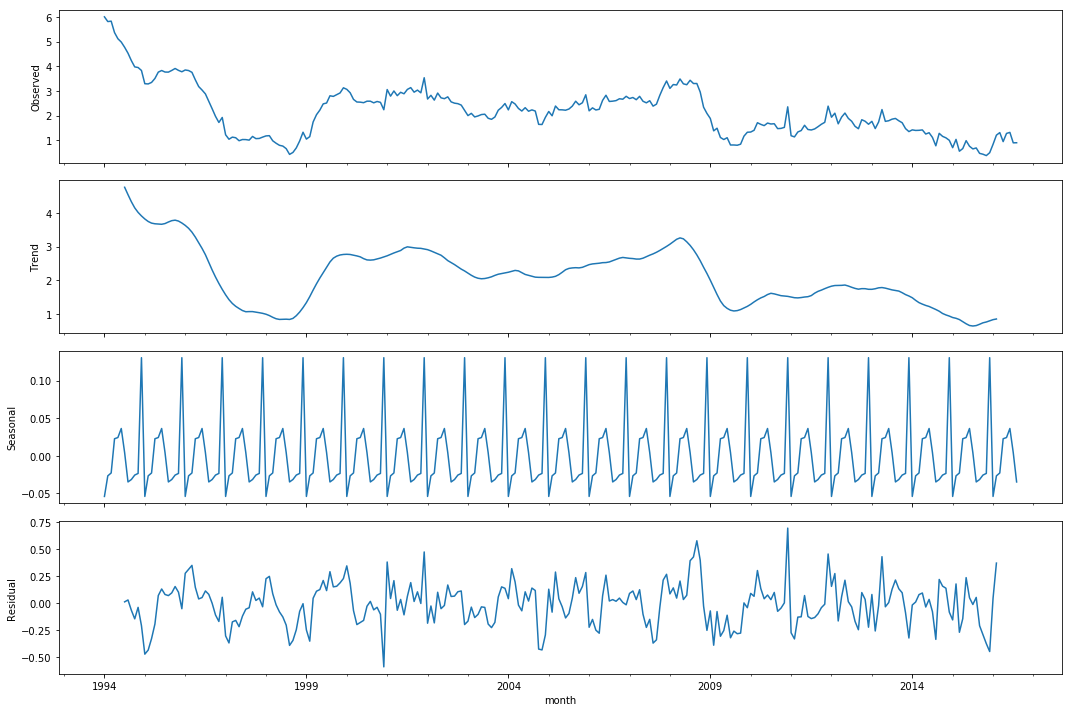

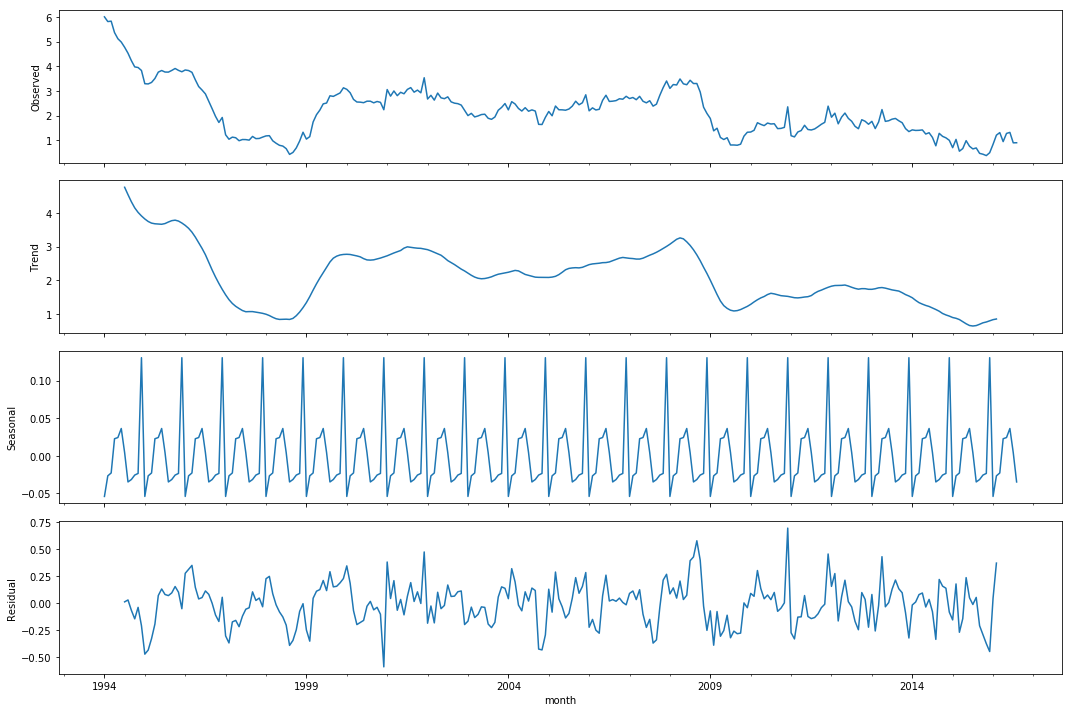

In [121]:
sm.tsa.seasonal_decompose(wage.wage_box_diff[12:]).plot()

Критерий Дики-Фуллера отвергает гипотезу о нестационарности, но на STL декомпозиции ряда мы видим, что все еще сохраняется тренд, и чтобы избавиться от него лучше еще раз продифференцировать ряд.

Критерий Дики-Фуллера: p=0.000000


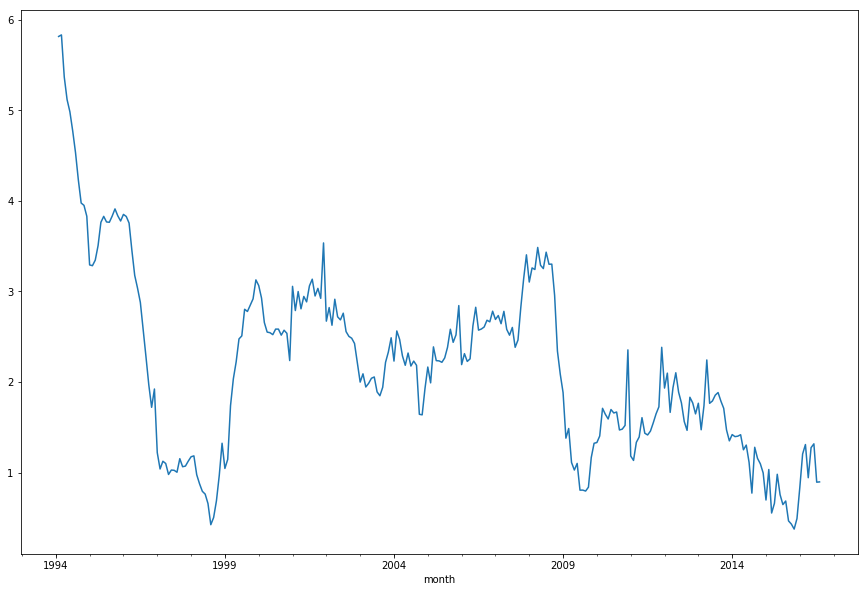

In [18]:
wage['wage_box_diff2'] = wage.wage_box_diff - wage.wage_box_diff.shift(1)
plt.figure(figsize(15,10))
wage.wage_box_diff[13:].plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wage.wage_box_diff2[13:])[1])

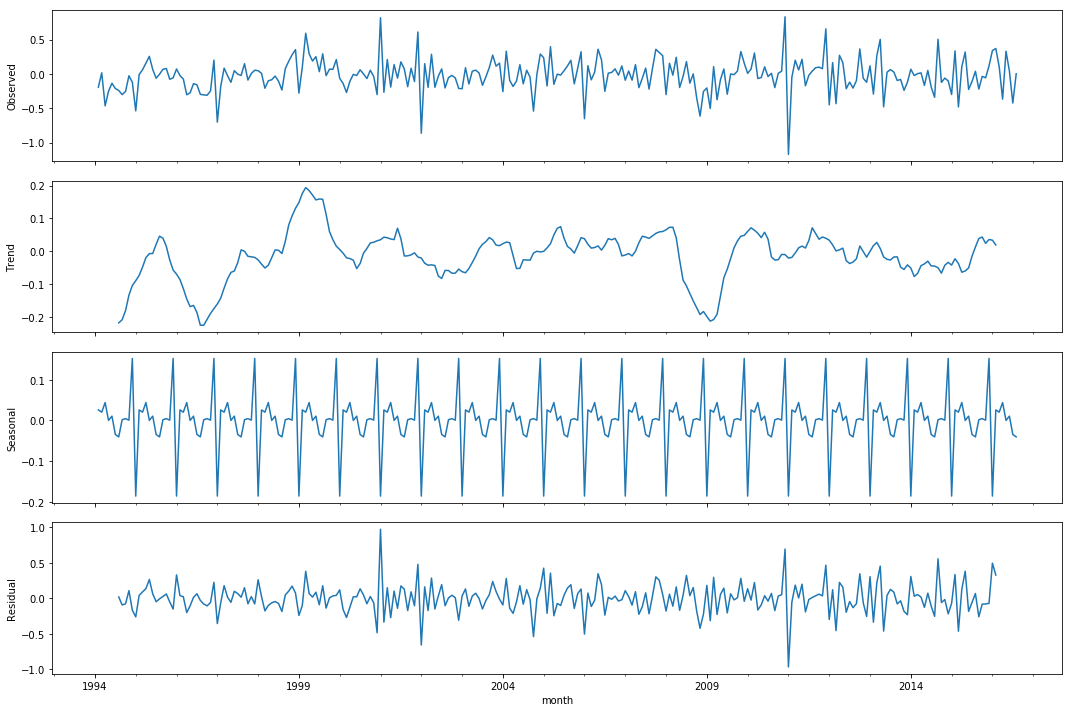

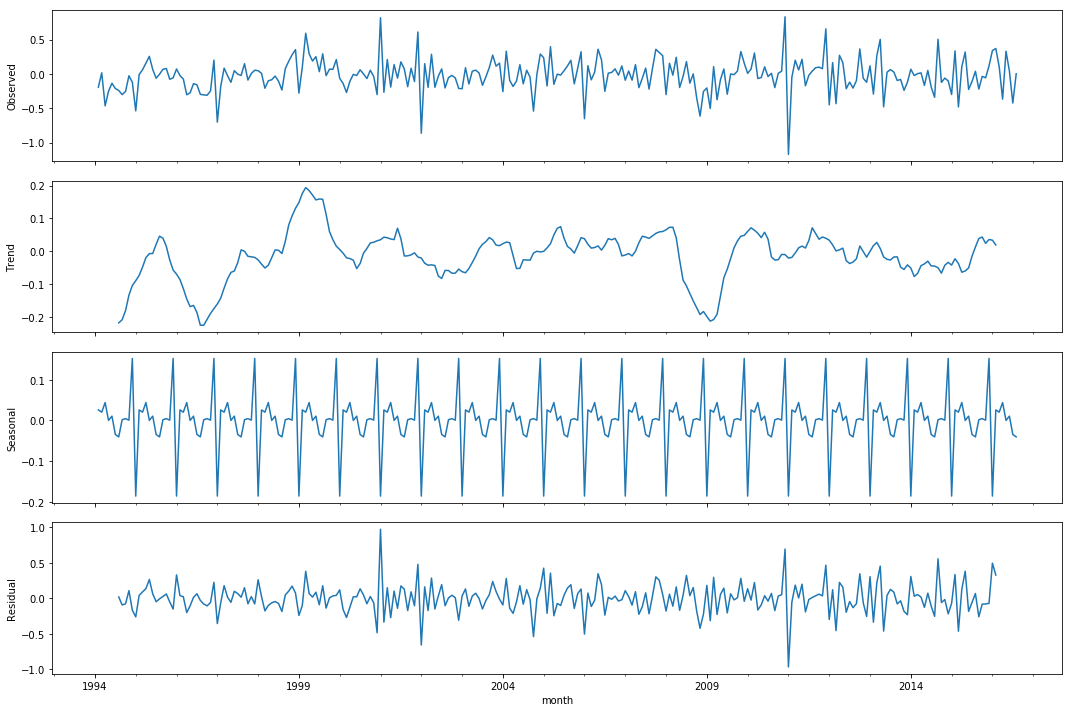

In [19]:
sm.tsa.seasonal_decompose(wage.wage_box_diff2[13:]).plot()

Как мы видим, после второго дифференцирования тренд исчез. Теперь построим графики автокорелляционной функции и частичной автокорреляционной функции и по ним определим начальное приближение.

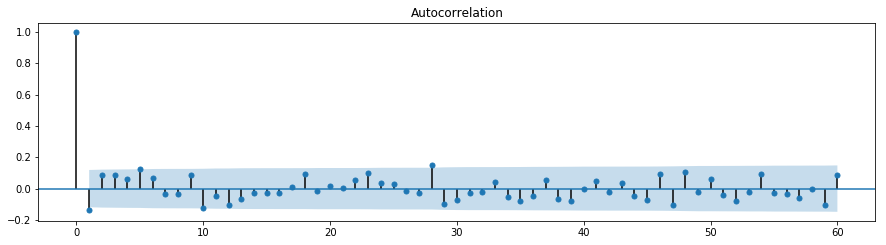

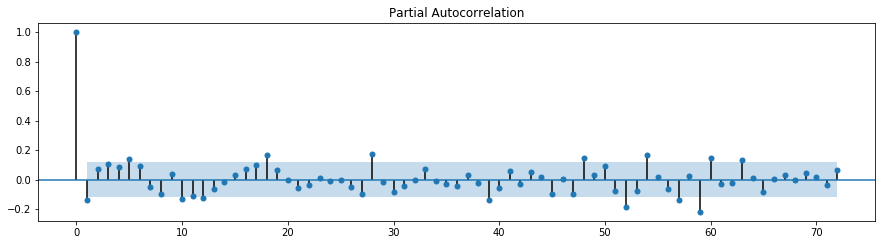

In [9]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(wage.wage_box_diff2[13:].values.squeeze(), lags=60, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(wage.wage_box_diff2[13:].values.squeeze(), lags=72, ax=ax)
pylab.show()

Начальные приближения: Q=0, q=10, P=6, p=11, однако значения начальных приближений p и q равные 10 и 11 слишком большие и подбираться оптимальные параметры будут очень долго, так что рассмотрим значения поменьше, p=5 и q=5.

In [11]:
ps = range(0, 6)
d=1
qs = range(0, 6)
Ps = range(0, 7)
D=1
Qs = range(0, 1)

In [12]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

252

Построим модели, сравним их по критерию Акаике и выберем ту, которая этот критерий минимизирует.

In [13]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(wage.wage_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (1, 2, 0, 0))
('wrong parameters:', (1, 2, 1, 0))
('wrong parameters:', (1, 2, 2, 0))
('wrong parameters:', (1, 2, 3, 0))
('wrong parameters:', (1, 2, 4, 0))
('wrong parameters:', (1, 2, 5, 0))
('wrong parameters:', (1, 2, 6, 0))
('wrong parameters:', (2, 1, 0, 0))
('wrong parameters:', (2, 1, 1, 0))
('wrong parameters:', (2, 1, 2, 0))
('wrong parameters:', (2, 1, 3, 0))
('wrong parameters:', (2, 1, 4, 0))
('wrong parameters:', (2, 1, 5, 0))
('wrong parameters:', (2, 1, 6, 0))
('wrong parameters:', (2, 2, 0, 0))
('wrong parameters:', (2, 2, 1, 0))
('wrong parameters:', (2, 2, 2, 0))
('wrong parameters:', (2, 2, 3, 0))
('wrong parameters:', (2, 2, 4, 0))
('wrong parameters:', (2, 2, 5, 0))
('wrong parameters:', (2, 2, 6, 0))
('wrong parameters:', (3, 2, 0, 0))
('wrong parameters:', (3, 2, 1, 0))
('wrong parameters:', (3, 2, 2, 0))
('wrong parameters:', (3, 2, 3, 0))
('wrong parameters:', (3, 2, 4, 0))
('wrong parameters:', (3, 2, 5, 0))
('wrong parameters:', (3, 2,

Даже несмотря на то, что мы выбрали не самые большие значимые несезонные автокорреляции, подбор параметров проходил довольно долго. Теперь взглянем на нашу лучшую модель.

In [15]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters        aic
167  (4, 5, 6, 0) -26.286968
183  (5, 5, 1, 0) -25.137734
162  (4, 5, 1, 0) -24.429799
188  (5, 5, 6, 0) -24.236208
184  (5, 5, 2, 0) -23.300529


In [17]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                           wage_box   No. Observations:                  284
Model:             SARIMAX(4, 1, 5)x(6, 1, 0, 12)   Log Likelihood                  29.143
Date:                            Sat, 23 Mar 2019   AIC                            -26.287
Time:                                    15:16:24   BIC                             31.347
Sample:                                01-01-1993   HQIC                            -3.146
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6272      0.158      3.968      0.000       0.317       0.937
ar.L2         -0.4108      0.065   

Критерий Стьюдента: p=0.453450
Критерий Дики-Фуллера: p=0.000000


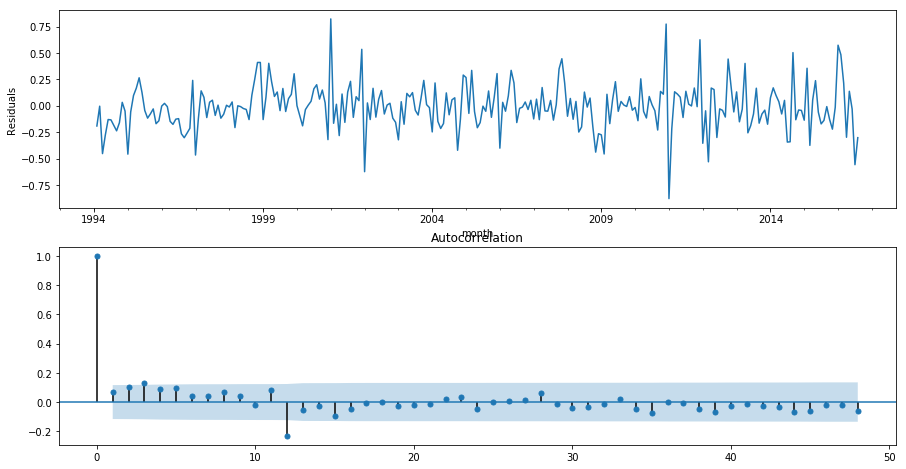

In [26]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid.values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid, 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid)[1])

Остатки несмещены, неавтокоррелированы и стационарны, значит в них не содержитс ккакой-то важной неучтенной информации.

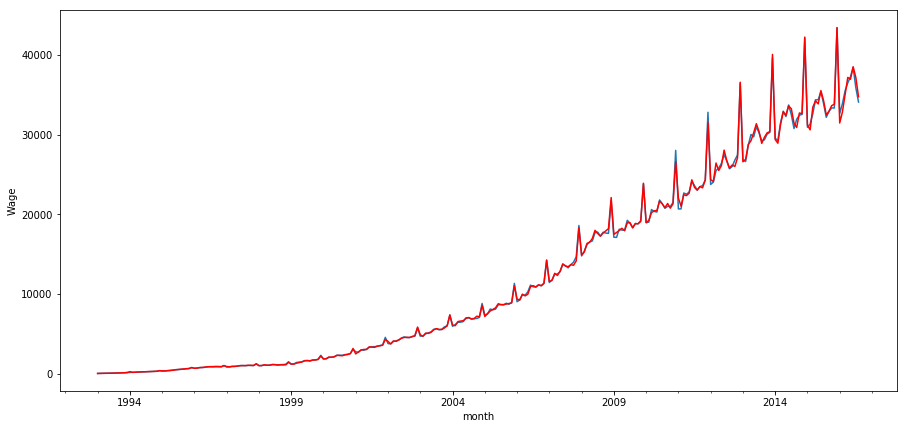

In [24]:
wage['model'] = invboxcox(best_model.fittedvalues, lmbd)
plt.figure(figsize(15,7))
wage.WAG_C_M.plot()
wage.model.plot(color='r')
plt.ylabel('Wage')
pylab.show()

Построенная модель достаточно хорошо описывает наши реальные данные. Теперь попробуем получить прогноз на следующий дваг ода

In [27]:
wage2 = wage[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= wage2.columns)
wage2 = pd.concat([wage2, future])
wage2['forecast'] = invboxcox(best_model.predict(start=284, end=308), lmbd)


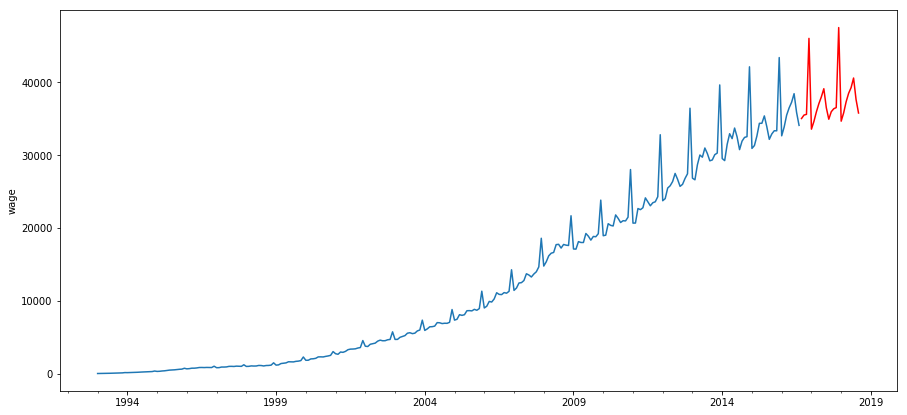

In [28]:
plt.figure(figsize(15,7))
wage2.WAG_C_M.plot()
wage2.forecast.plot(color='r')
plt.ylabel('wage')
pylab.show()

Визуально прогноз выглядит достаточно хорошим и логичным.